# Simple Linear Regression

The name *simple linear regression* refers to a linear regression model with only a single predictor, or input variable $x$, a single output variable $y$, and Gaussian distributed model errors. The model is written as follows

$$ y = \beta_0 + \beta_1x + \epsilon, $$

where $\beta_0$ and $\beta_1$ are the parameters and $\epsilon$ is a Gaussian variable with zero mean and variance $\sigma^2$, or $\epsilon \sim N(0,\sigma^2)$. In the classical approach we estimate the parameters of the model via maximum likelihood, which has the familiar closed form solution for the best fitting parameters

$$ \hat{\mathbf{\beta}} = (X'X)^{-1}X'y  $$

with 

$$ \hat{\sigma^2} = \frac{1}{N-1} \sum_{i=1}^{N} (y_i - \hat{\beta_0} + \hat{\beta_1}x_i)^2  $$

and 'standard error'

$$  se(\mathbf{\beta}) = \frac{\hat{\sigma}}{\sum_{i=1}^N (x_i - \bar{x})^2}.$$

PLACEHOLDER: hypothesis test

We can write the same model in hierarchical Bayesian form

$$ p(y | x, \beta) \sim N(\beta_0 + \beta_1x,\sigma^2) $$

$$ p(\beta_0) \sim uniform(a_1,b_1) $$

$$ p(\beta_1) \sim uniform(a_2,b_2) $$

In [1]:
SLR = """
data{
	int N; 			//length of dataset
	vector[N] y;	//response observations
	vector[N] x;	//input observations
}
parameters{
	real beta0;
	real beta1;
	real<lower=0> sigma;
}
model{
	beta0 ~ uniform(-1,1);				//prior on beta0, uniform density on (-1,1)
	beta1 ~ uniform(-1,1);				//prior on beta1
	y ~ normal(beta0 + beta1*x, sigma);	//likelihood model; p(y|x,beta0,beta1,sigma) ~ Gaussian 
}
generated quantities{
	vector[N] y_pred;     //predictive distribution
	vector[N] log_lik;    //marginal log likelihood for model comparison later on

	for (i in 1:N)
		y_pred[i] = beta0 + beta1*x[i];                              //generate prediction for y within MCMC step for parameters
	for (i in 1:N)
		log_lik[i] = normal_lpdf(y[i] | beta0 + beta1*x[i], sigma);  //compute marginal log-likelihood within MCMC
}
"""

In [2]:
#-- Import Packages
import pystan
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#-- Compile C++ model
mod_slr = pystan.StanModel(model_code=SLR)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0bb3b2d581d501c8780c03b2cdec4f92 NOW.


In [18]:
#-- Read data from csv file
with open(os.path.expanduser('~/DSI_course.dir/data/ozone_Riverside_epa.csv')) as f:
    content = f.readlines()

#-- get indices for ozone and temperature columns.
headers = np.array(content[0].split("\",\"")) #split column headers
temp_ind = np.squeeze(np.nonzero(headers=='temp'))
oz_ind = np.squeeze(np.nonzero(headers=='Arithmetic.Mean'))

#-- Now get the corresponding columns
temp = []# np.zeros(len(content)-1) #initalize, skipping header line
oz = [] #np.zeros(len(content)-1)
for i in range(1,len(content)):
    line = np.array(content[i].replace('\"','').split(',')) #split row and take out quotations
    #-- Skip 'NA' temperatures
    if line[temp_ind]!='NA':
        temp.append(np.float(line[temp_ind]))
        oz.append(np.float(line[oz_ind]))

#-- Subsample larger dataset into a dictionary for stan
stan_dat = {'N':200,'y':oz[:200],'x':temp[:200]}

In [19]:
#-- MCMC sampling
fit = mod_slr.sampling(data=stan_dat)
#fit = pystan.stan(model_code=mod_slr, data=stan_dat,iter=1000, chains=4)
#-- Extract
post = fit.extract()
post_keys = post.keys()
for k in post_keys:
    print('%s: length %i'%(k,len(post[k])))

beta0: length 4000
beta1: length 4000
sigma: length 4000
y_pred: length 4000
log_lik: length 4000
lp__: length 4000


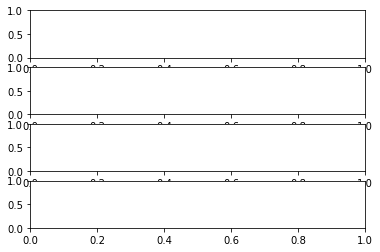

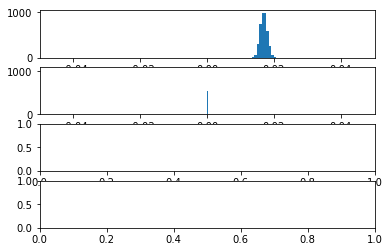

In [21]:
#-- Plot Histograms
fig, ax = plt.subplots(4)
#-- Beta0
ax[0].hist(post['beta0'])
ax[0].set_xlim([-0.05,0.05])
#-- Beta1
ax[1].hist(post['beta1'])
ax[1].set_xlim([-0.05,0.05])
plt.show()